In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from pyvinecopulib import Bicop, BicopFamily

In [4]:
tickers = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD",
    "NASDAQ-100 ETF": "QQQ",
    "Silver (spot)": "XAG-USD",
    "High-Yield Bond ETF": "HYG",
}

df = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
df.columns = list(tickers.keys())
returns = np.log(df).diff().dropna()

C:\Users\susha\AppData\Local\Temp\ipykernel_159288\2075308445.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
[*********************100%***********************]  5 of 5 completed


In [5]:
returns

,BTC,ETH,NASDAQ-100 ETF,Silver (spot),High-Yield Bond ETF
Date,,,,,
2020-08-13,0.017049,0.092085,-0.002728,0.002278,0.003720
2020-08-14,-0.001296,0.019988,-0.001782,-0.001175,-0.028532
2020-08-18,-0.021709,-0.013741,0.001536,0.009579,0.177760
2020-08-19,-0.019618,-0.041458,-0.002837,-0.006750,0.043120
2020-08-20,0.010161,0.024247,0.003310,0.013777,-0.014597
...,...,...,...,...,...
2023-09-28,0.025063,0.034086,0.004752,0.008331,0.000000
2023-09-29,-0.004073,0.009071,-0.001490,0.000726,0.000000
2023-10-03,-0.003668,-0.004181,-0.010204,-0.017705,0.000000


In [6]:
#probability integrity transform
def pseudo_obs(series):
    r = stats.rankdata(series, method="average")
    return r / (len(series) + 1.0)

U = returns.apply(pseudo_obs, axis=0)

In [7]:
def fit_bb7_conditional_prob(u1, u2, alpha=0.05, mc_N=20000, family_force='bb7'):
    """
    Fit BB7 to (u1,u2) pseudo-observations (numpy arrays).
    Returns conditional probability p = C(alpha,alpha)/alpha.
    If BB7 fit fails, falls back to Bicop.select over families and uses best model.
    """
    # Prepare input for pyvinecopulib: n x 2 numpy array
    data = np.column_stack([u1, u2]).astype(float)

    # small input checks
    if data.shape[0] < 50:
        # Not enough data for stable BB7 fit
        warnings.warn("Fitting on small sample (<50). Estimates may be noisy.")
    # Clip to (0,1) to avoid edge numerical problems
    data = np.clip(data, 1e-8, 1 - 1e-8)

    # Try to instantiate a BB7 bicop and fit with MLE
    try:
        # Bicop.from_family accepts family identifier; we can use BicopFamily.bb7 or string 'bb7'
        # Note: you can also set rotate=0 if you want no rotation
        bicop = Bicop.from_family("bb7")   # family 'bb7' (Joe-Clayton / BB7)
        bicop.fit(data)  # MLE fit (default controls)
    except Exception as e:
        # fallback: try to select best family automatically (this will try multiple families)
        warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
        bicop = Bicop.from_data(data)  # this will select/fit automatically with default controls
        try:
            bicop.select(data)  # explicit selection (family search)
        except Exception:
            # if select fails, keep the bicop fitted from from_data()
            pass

    # Evaluate C(alpha, alpha) using bicop.cdf
    u_query = np.array([[alpha, alpha]], dtype=float)
    try:
        # bicop.cdf returns a 1d array; use mc_N quasi MC samples for numerical integration if required
        C_aa = float(bicop.cdf(u_query, N=mc_N)[0])
    except Exception as e:
        # As a last resort, approximate C(u,u) by empirical count (consistent fallback)
        warnings.warn(f"bicop.cdf failed, using empirical fallback for C({alpha},{alpha}). Reason: {e}")
        mask = (u1 < alpha) & (u2 < alpha)
        C_aa = mask.sum() / len(u1)

    # compute conditional probability p = C(alpha,alpha)/alpha
    p = C_aa / alpha
    # Force [0,1] range numerically
    p = float(np.clip(p, 0.0, 1.0))

    # also return family name for diagnostics
    fam = bicop.family.name if hasattr(bicop.family, 'name') else str(bicop.family)
    return p, C_aa, fam

In [8]:
assets = U.columns.tolist()
n = len(assets)
alpha = 0.05
W = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)
family_matrix = pd.DataFrame("", index=assets, columns=assets)

for i_idx, i in enumerate(assets):
    for j_idx, j in enumerate(assets):
        if i == j:
            continue
        u_i = U.iloc[:, i_idx].to_numpy()
        u_j = U.iloc[:, j_idx].to_numpy()
        p, C_aa, fam = fit_bb7_conditional_prob(u_i, u_j, alpha=alpha, mc_N=20000)
        W.loc[i, j] = p
        family_matrix.loc[i, j] = fam

print("Conditional tail-probability matrix P(i|j):\n", W.round(3))
print("\nFitted family matrix (per pair):\n", family_matrix)

C:\Users\susha\AppData\Local\Temp\ipykernel_159288\4055276143.py:25: UserWarning: BB7 fit failed, falling back to automatic selection. Reason: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection. Reason: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_159288\4055276143.py:40: UserWarning: bicop.cdf failed, using empirical fallback for C(0.05,0.05). Reason: cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: py

Conditional tail-probability matrix P(i|j):
                        BTC    ETH  NASDAQ-100 ETF  Silver (spot)  \
BTC                  0.000  0.609           0.224          0.321   
ETH                  0.609  0.000           0.224          0.321   
NASDAQ-100 ETF       0.224  0.224           0.000          0.513   
Silver (spot)        0.321  0.321           0.513          0.000   
High-Yield Bond ETF  0.096  0.096           0.224          0.160   

                     High-Yield Bond ETF  
BTC                                0.096  
ETH                                0.096  
NASDAQ-100 ETF                     0.224  
Silver (spot)                      0.160  
High-Yield Bond ETF                0.000  

Fitted family matrix (per pair):
                           BTC       ETH NASDAQ-100 ETF Silver (spot)  \
BTC                              gumbel            bb1      gaussian   
ETH                    gumbel                      bb1           bb1   
NASDAQ-100 ETF            bb1       b

In [9]:
G = nx.DiGraph()
G.add_nodes_from(assets)
for i in assets:
    for j in assets:
        if i == j:
            continue
        w = W.loc[i, j]
        # optional threshold to reduce noise
        if w > 0.01:
            G.add_edge(j, i, weight=float(w))

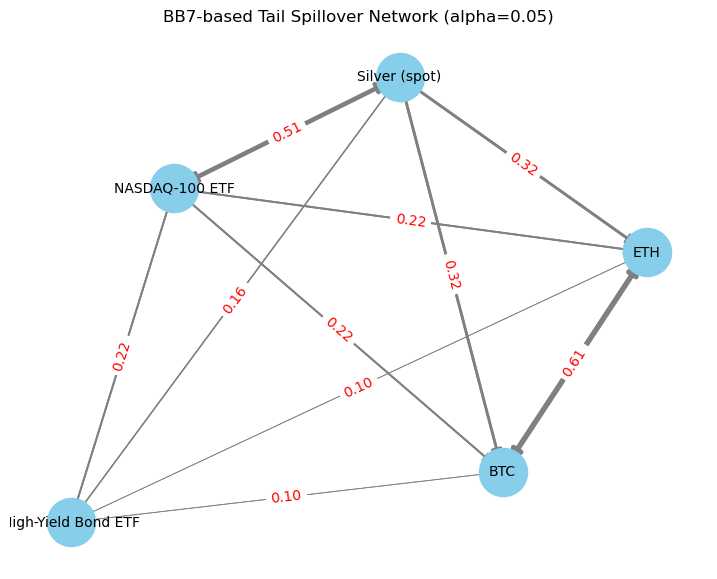

In [10]:
plt.figure(figsize=(9,7))
pos = nx.spring_layout(G, seed=2)
weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color='gray',
                       arrowsize=16,
                       width=[max(0.5, 6*w) for w in weights])
edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title(f"BB7-based Tail Spillover Network (alpha={alpha})")
plt.axis('off')
plt.show()

In [11]:
from numpy.linalg import eigvals

def connectedness_index(W, alpha = 0.05):
    J = W.copy()                    # DataFrame NxN where J[i,j] = C_aa(i,j)
    np.fill_diagonal(J.values, alpha)  # set diagonal to marginal P(U_i<=alpha) (or empirical)
    return 100.0 * (J.values.sum() - np.trace(J.values)) / (J.values.sum() + 1e-12)

def spectral_radius(W):
    A = (W + W.T) / 2.0
    eigs = eigvals(A)
    return float(np.max(eigs.real))

ci = connectedness_index(W.values)
rho = spectral_radius(W)

# Standardize and compute SRI
#df['zCI'] = (df['CI'] - df['CI'].mean()) / df['CI'].std(ddof=0)
#df['zRho'] = (df['Rho'] - df['Rho'].mean()) / df['Rho'].std(ddof=0)
#df['SRI'] = df['zCI'] * df['zRho']

#df[['CI','Rho','SRI']].plot(title='Unified Systemic Risk Index (SRI)')


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [36]:
ci

99.99999999996055

In [38]:
rho

0.6555371227590907